In [11]:
import numpy as np
import torch
import os
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import soundfile as sf
from collections import OrderedDict

from diff_gfdn.config.config import DiffGFDNConfig
from diff_gfdn.utils import get_response
from diff_gfdn.solver import data_parser_var_receiver_pos
from diff_gfdn.colorless_fdn.model import ColorlessFDN

os.chdir('..')  # This changes the working directory to DiffGFDN
import sys
sys.path.append('/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/projects/orchi/DiffGFDN/src')
sys.path.append('/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/projects/orchi/DiffGFDN/src/run_model.py')
from run_model import load_and_validate_config


In [12]:
project_dir = '/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/projects/orchi/DiffGFDN/'
config_path = '/data/config/'
fig_path = 'figures/'
config_name = 'treble_data_grid_training_500Hz_colorless_loss_gds_local.yml'
config_file = project_dir + config_path + config_name

with open(config_file, 'r') as file:
    config_data = yaml.safe_load(file)

config_dict = DiffGFDNConfig(**config_data)

trainer_config = config_dict.trainer_config
checkpoint_dir = Path(trainer_config.train_dir + 'checkpoints/').resolve()
max_epochs = config_dict.colorless_fdn_config.max_epochs

In [13]:
num_freq_samples = trainer_config.num_freq_bins
mag = torch.ones(num_freq_samples)
angle = angle = torch.arange(0, 1, 1 / num_freq_samples)
data = torch.polar(mag, angle * np.pi) 

room_data = data_parser_var_receiver_pos(
    config_dict, num_freq_bins=trainer_config.num_freq_bins)

config_dict = config_dict.copy(update={"num_groups": room_data.num_rooms})

# create folder where to save the impulse responses 
output_dir = Path(trainer_config.train_dir + 'colorless-fdn/' + 'audio').resolve()  
os.makedirs(output_dir, exist_ok=True)



2025-02-24 11:34:17.578 | INFO     | diff_gfdn.dataloader:__init__:432 - Reading pkl file ...
2025-02-24 11:34:17.885 | INFO     | diff_gfdn.dataloader:__init__:449 - Done reading pkl file
2025-02-24 11:34:20.454 | INFO     | diff_gfdn.dataloader:__init__:477 - Saving RIRs


2025-02-24 11:35:29.004 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


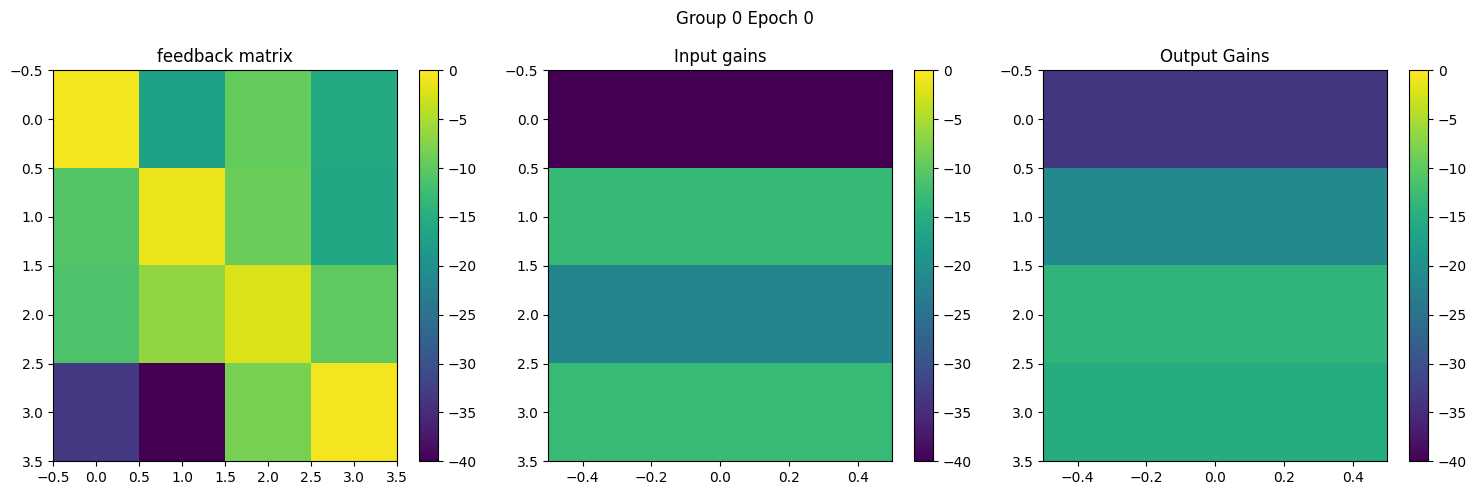

2025-02-24 11:35:30.032 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


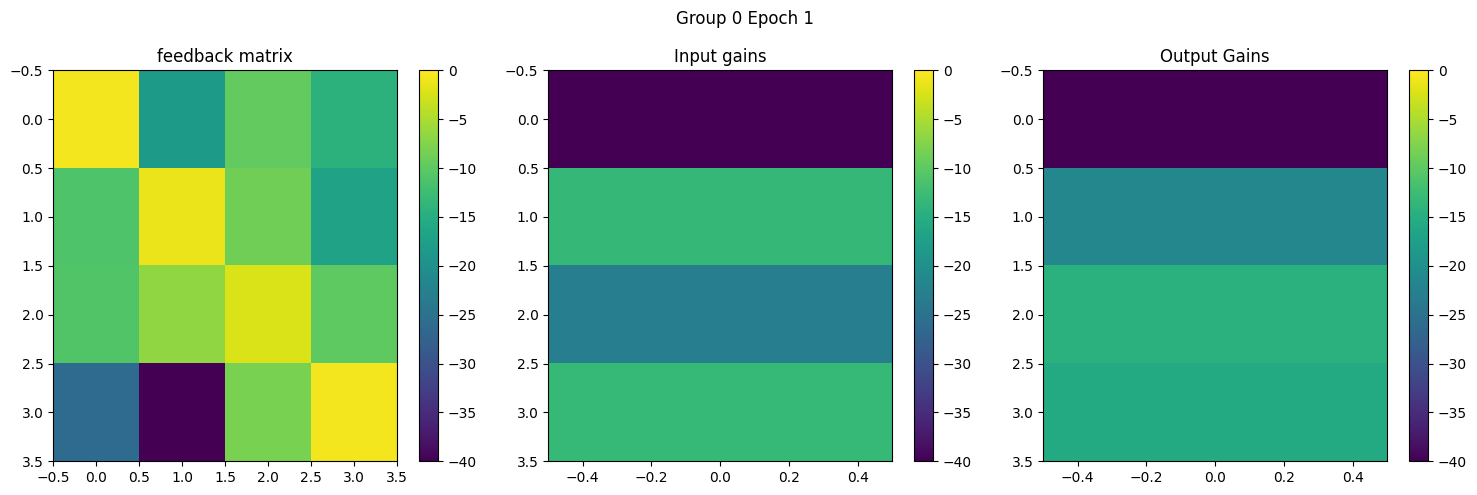

2025-02-24 11:35:30.869 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


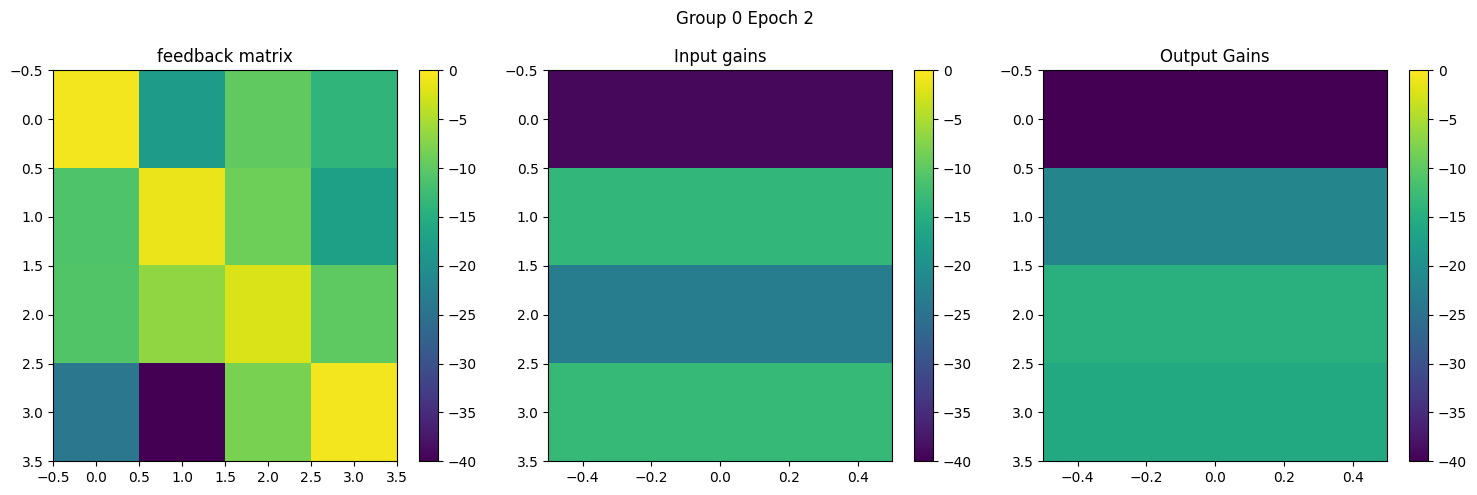

2025-02-24 11:35:31.668 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


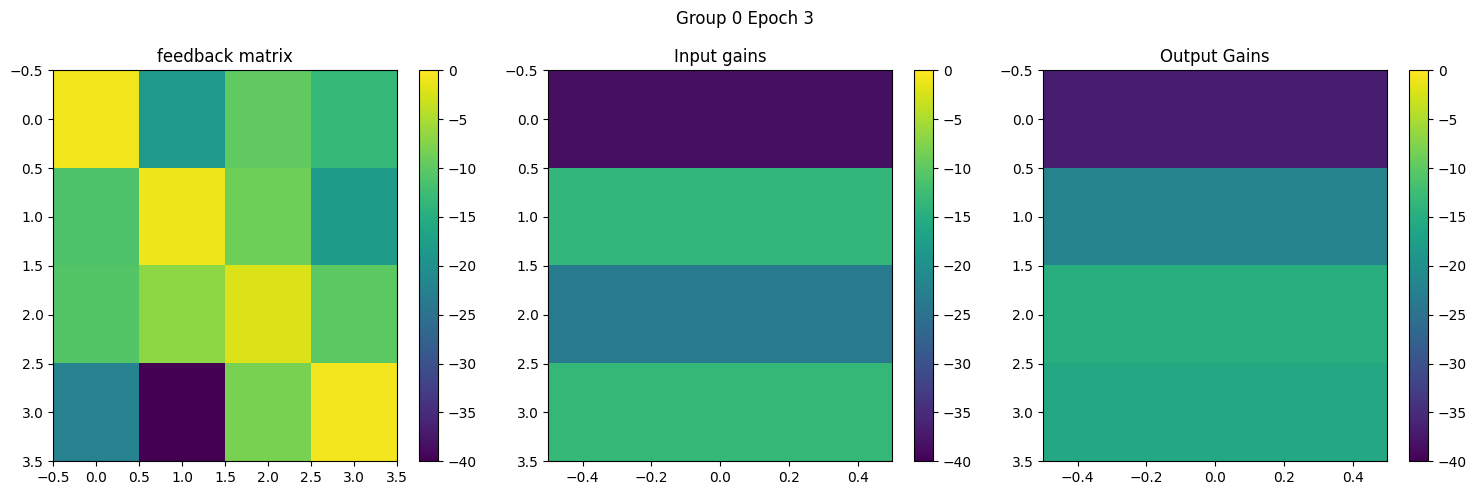

2025-02-24 11:35:32.451 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


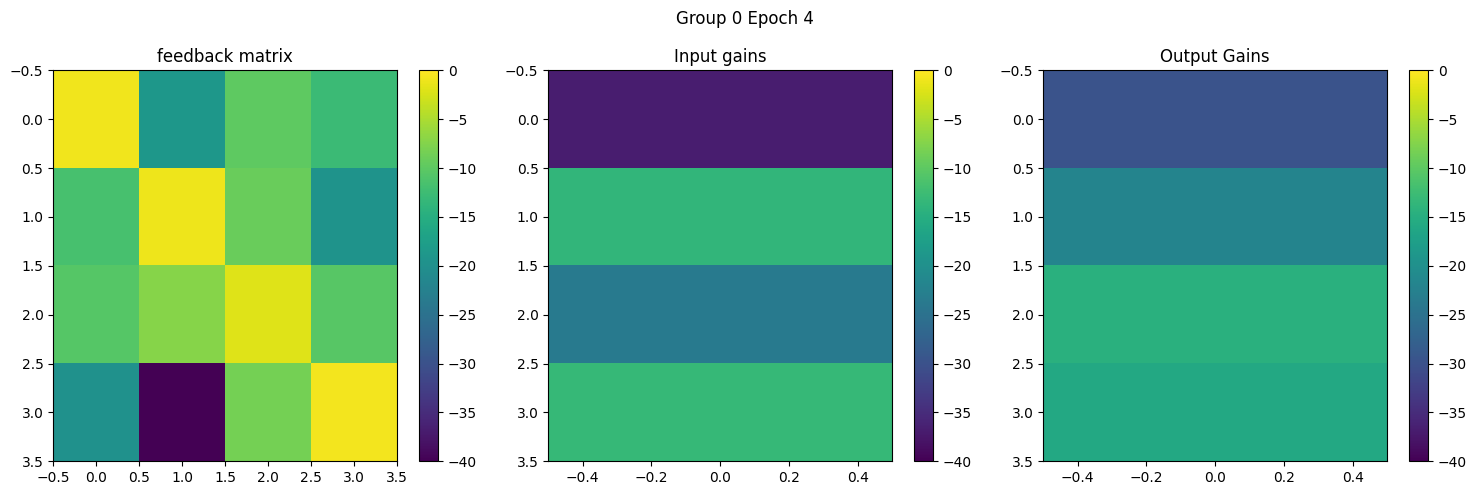

2025-02-24 11:35:33.252 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


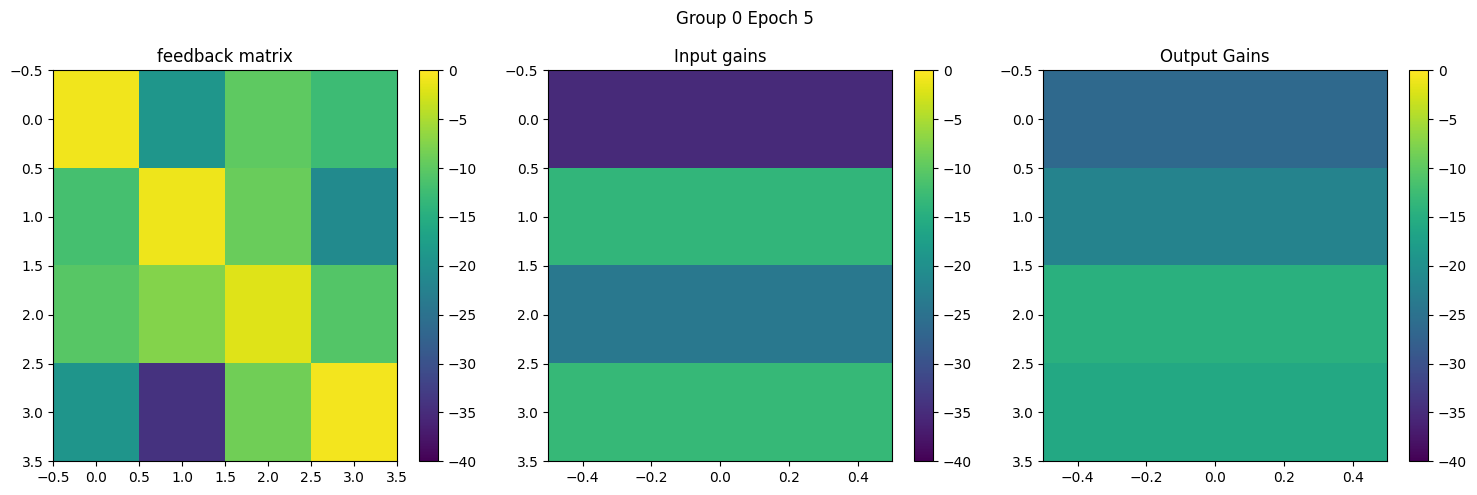

2025-02-24 11:35:34.143 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


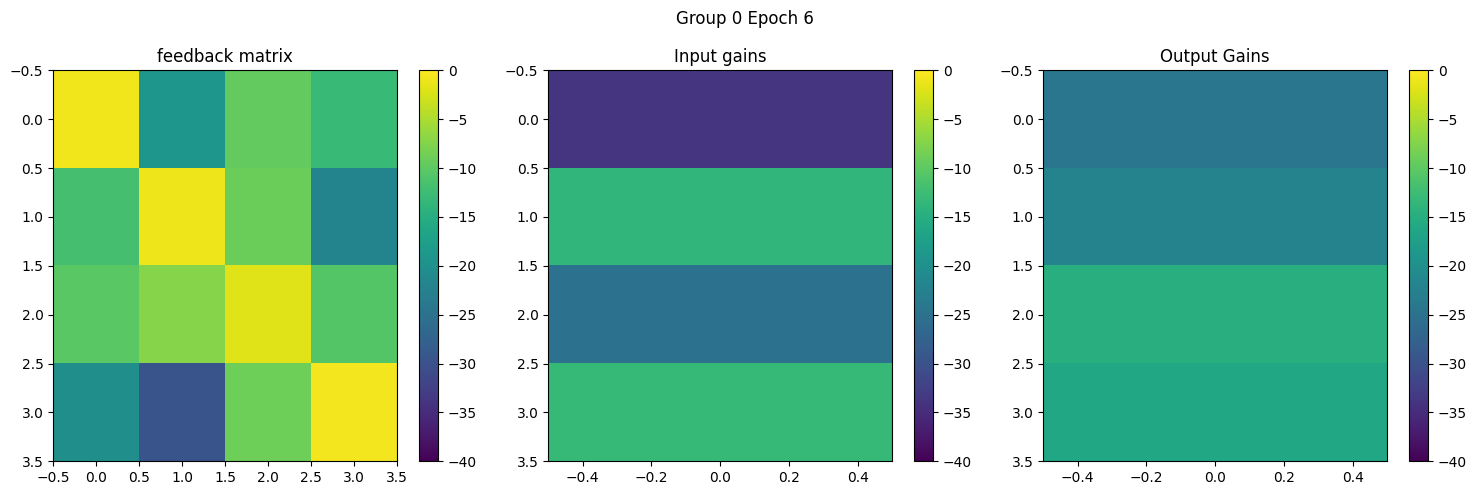

2025-02-24 11:35:35.010 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


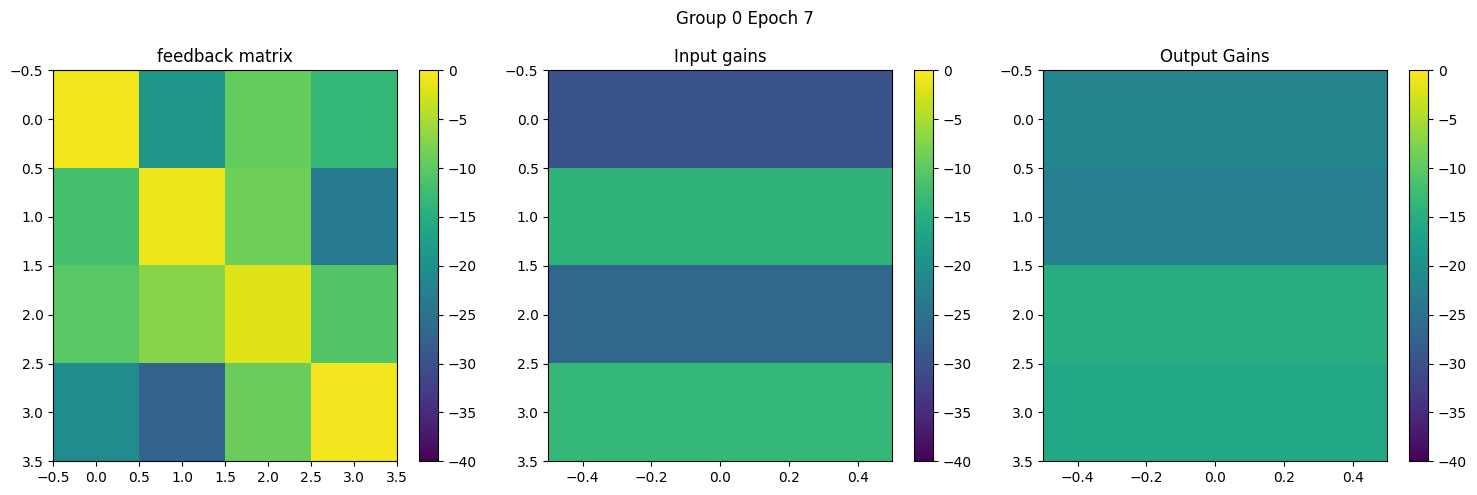

2025-02-24 11:35:35.800 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


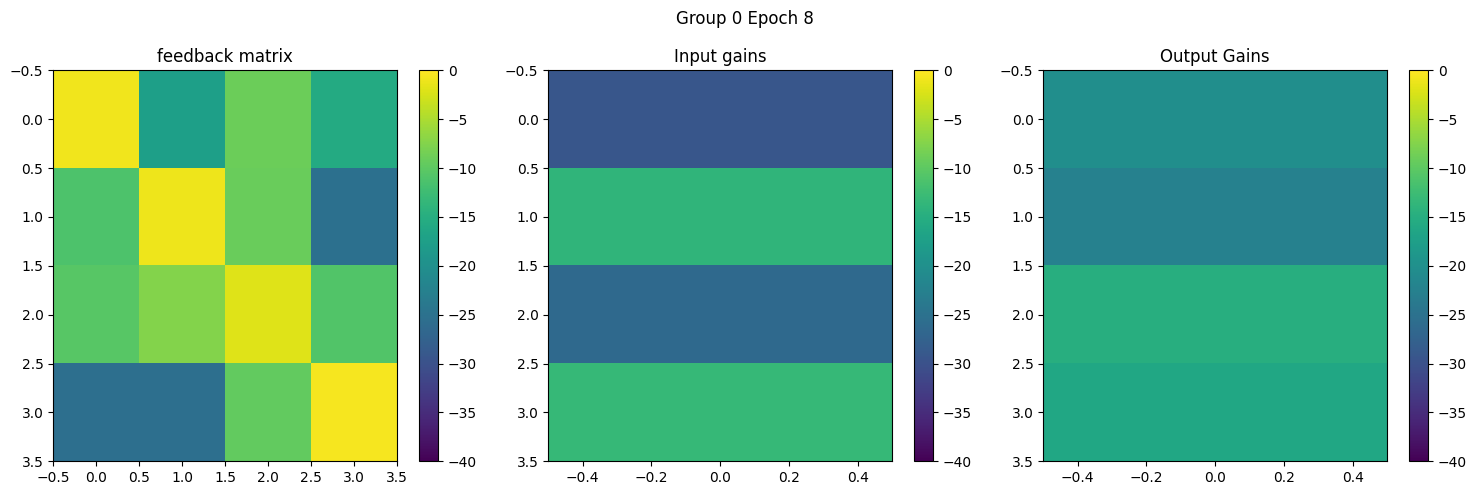

2025-02-24 11:35:36.588 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


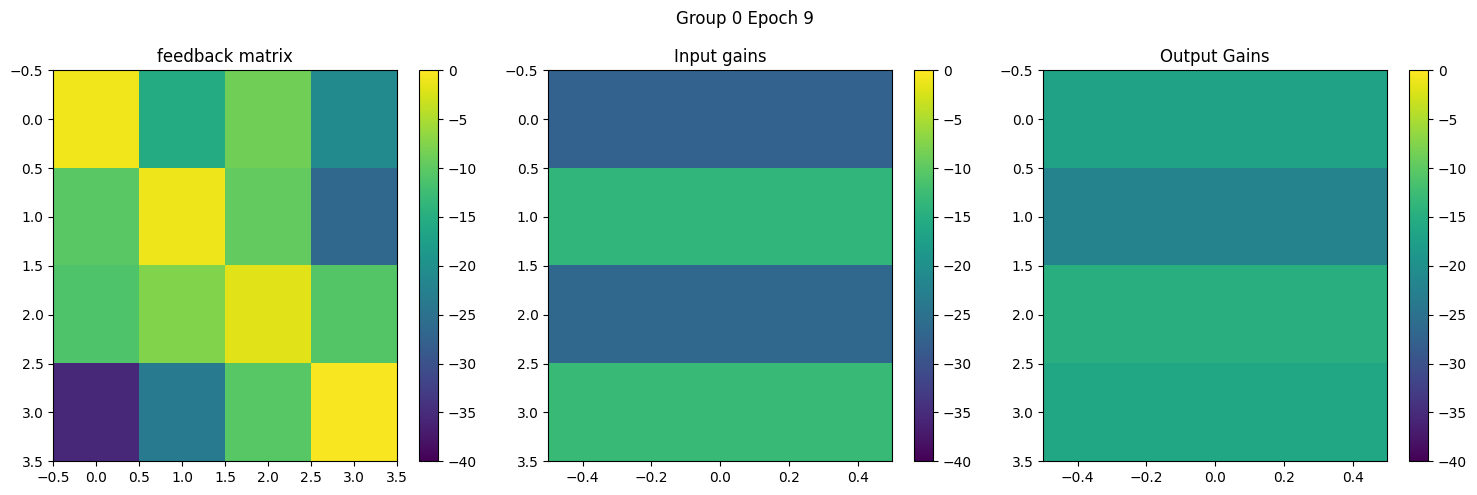

2025-02-24 11:35:37.400 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


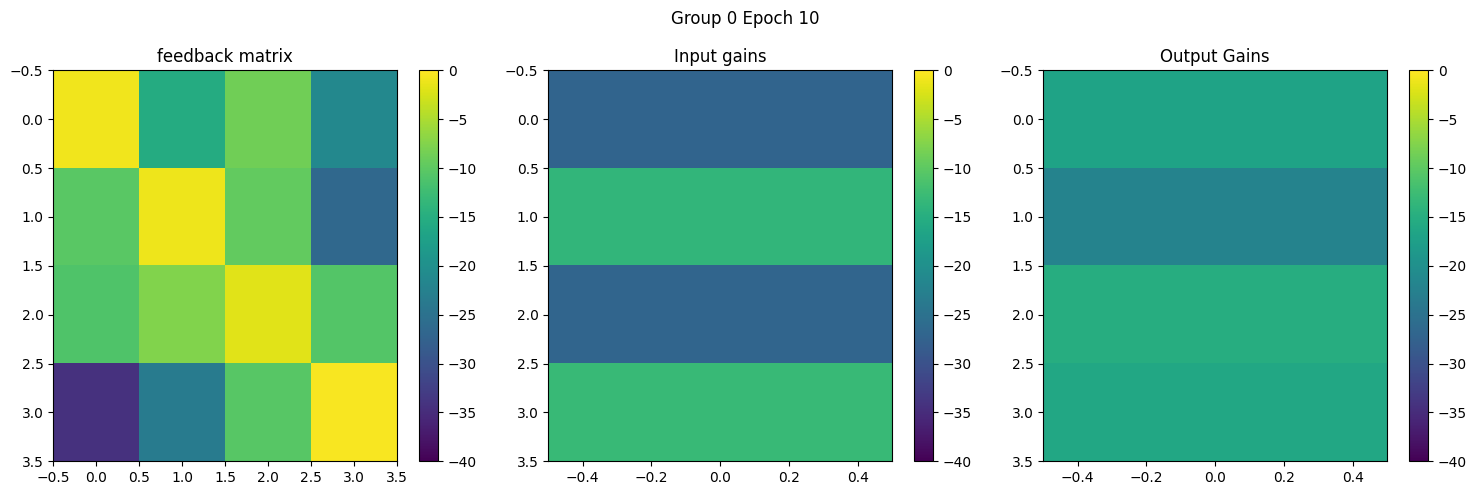

2025-02-24 11:35:38.404 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


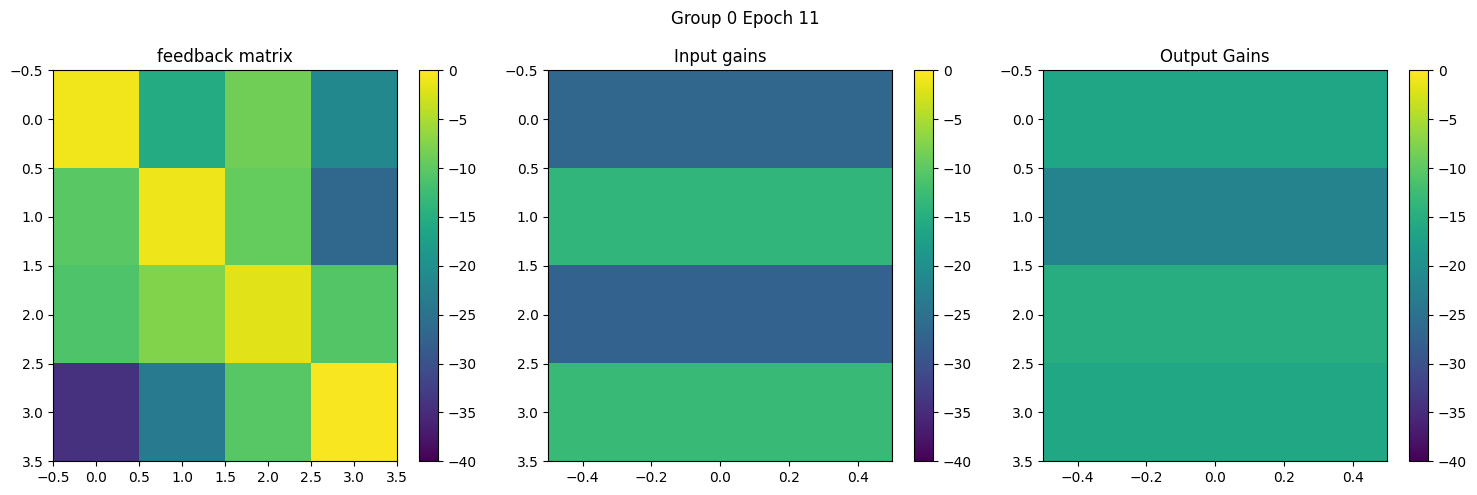

2025-02-24 11:35:39.217 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


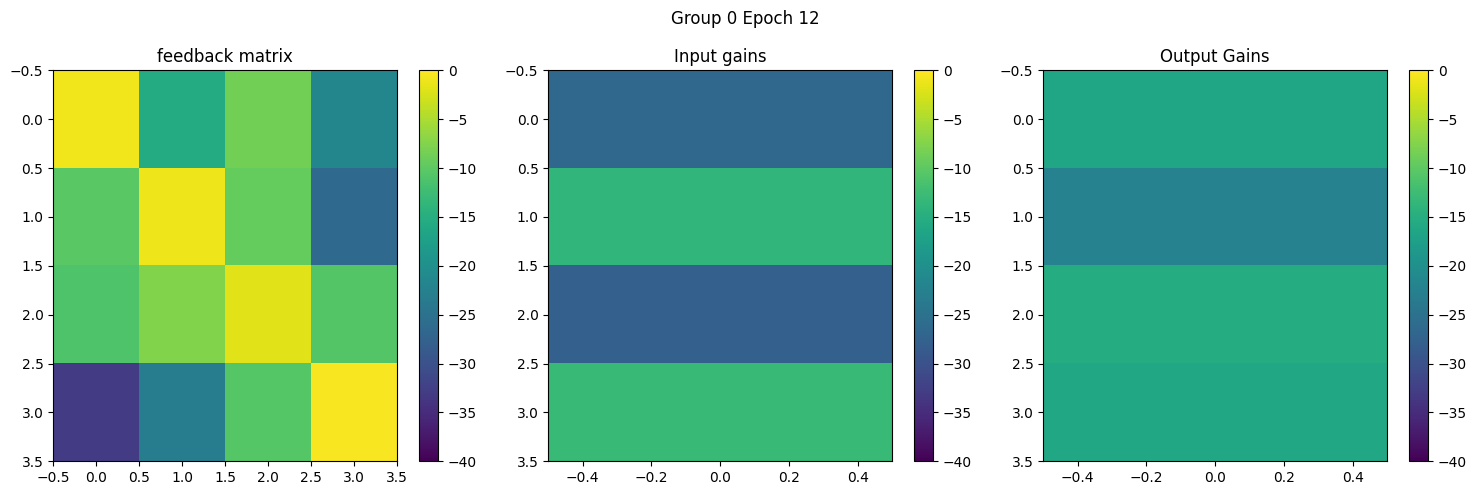

2025-02-24 11:35:40.073 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


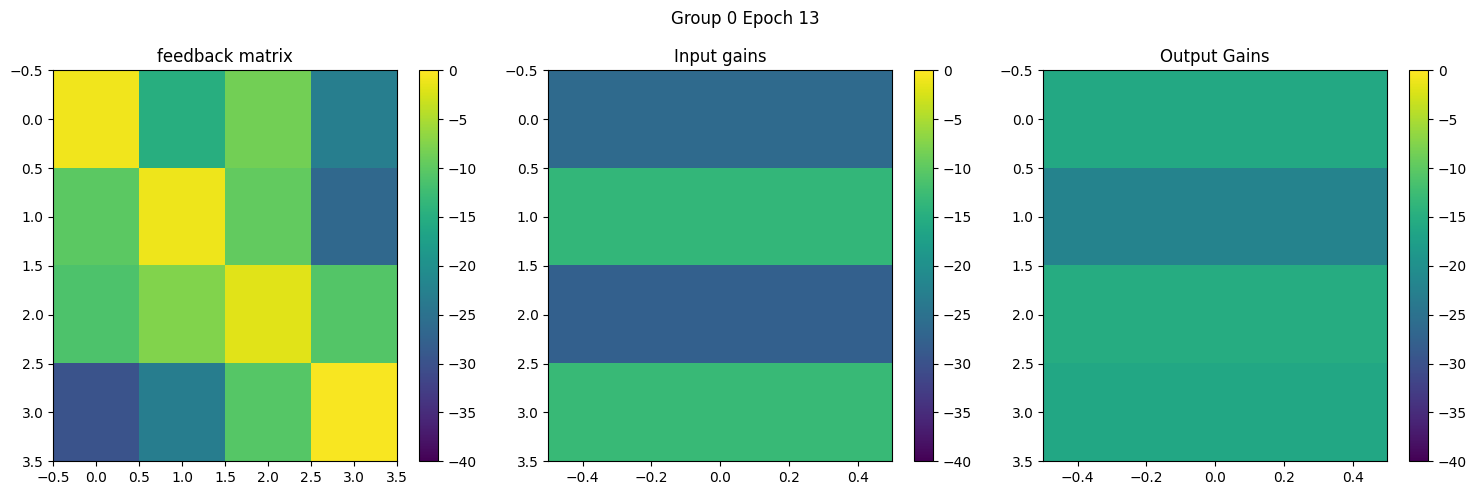

2025-02-24 11:35:40.888 | WARNING  | diff_gfdn.utils:get_response:161 - 'ColorlessFDN' object has no attribute 'use_colorless_loss'


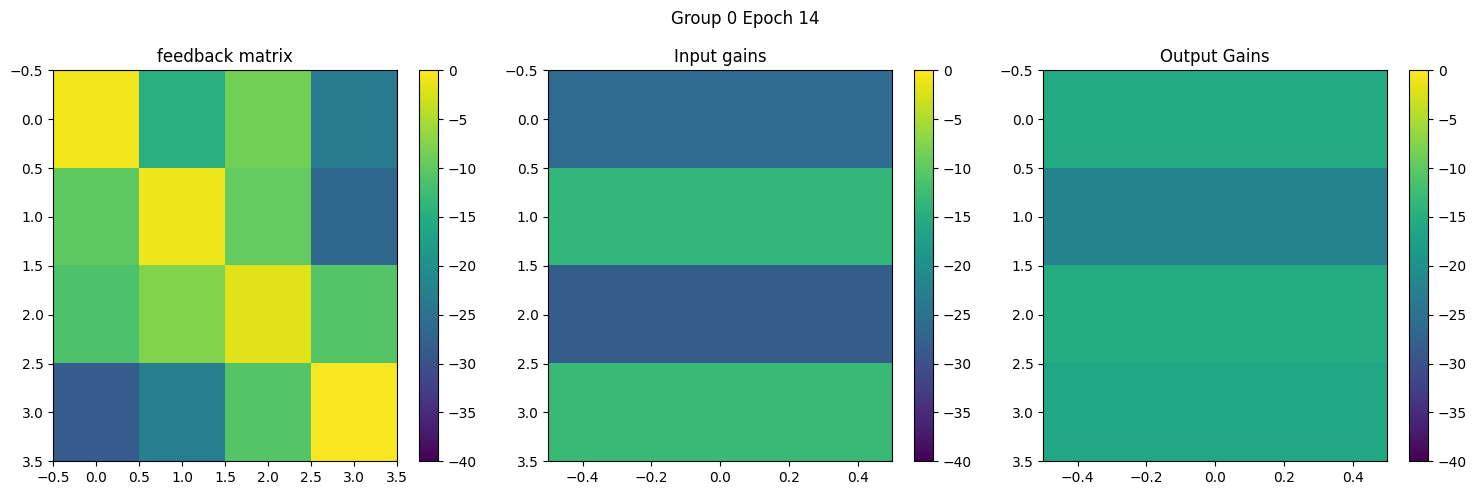

No checkpoint found for epoch 15
No checkpoint found for epoch 16
No checkpoint found for epoch 17
No checkpoint found for epoch 18
No checkpoint found for epoch 19


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

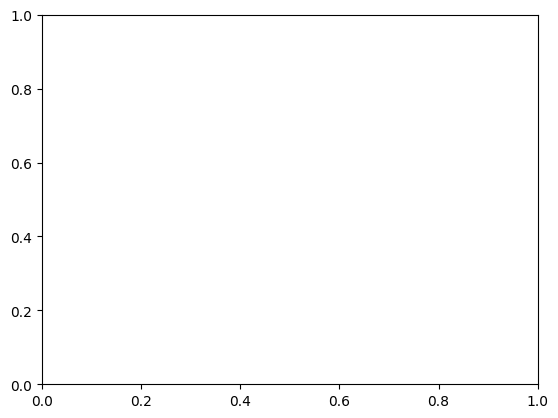

In [15]:
num_delay_lines_per_group = int(config_dict.num_delay_lines /
                                config_dict.num_groups)

ortho_map = lambda x: torch.matrix_exp(x.triu(1) - (x.triu(1)).transpose(-1, -2))
N = num_delay_lines_per_group

for i in range(config_dict.num_groups):
    indx = list(range(i * num_delay_lines_per_group, (i + 1) * num_delay_lines_per_group))
    model = ColorlessFDN(
        config_dict.sample_rate,
        [config_dict.delay_length_samps[idx] for idx in indx],
        trainer_config.device)
    sparsity_loss = []
    mse_loss = []
    for epoch in range(max_epochs):
        # load the trained weights for the particular epoch
        try: 
            checkpoint = torch.load(f'{checkpoint_dir}/model_e{epoch}.pt', weights_only=True, map_location=torch.device('cpu'))
        except:
            print(f'No checkpoint found for epoch {epoch}')
            continue
        # Load the trained model state
        current_checkpoint = OrderedDict()
        current_checkpoint['input_gains'] = torch.tensor([checkpoint['input_gains'][idx] for idx in indx]).unsqueeze(-1)
        current_checkpoint['output_gains'] = torch.tensor([checkpoint['output_gains'][idx] for idx in indx]).unsqueeze(-1)
        current_checkpoint['feedback_loop.random_feedback_matrix'] = checkpoint['feedback_loop.M'][i]
        model.load_state_dict(current_checkpoint)
        # in eval mode, no gradients are calculated
        model.eval()
        # get the response of the model
        H, h = get_response(data, model)
        # plot the impulse response
        sf.write(os.path.join(output_dir,f'model_e{epoch}_g{i}.wav'), h, int(config_dict.sample_rate))
        # plot the matrix 
        feedback_loop = model.feedback_loop
        input_gains = model.input_gains.detach().numpy()
        output_gains = model.output_gains.detach().numpy()

        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(20*np.log10(np.abs(feedback_loop.ortho_param(feedback_loop.random_feedback_matrix).detach().numpy())), aspect='auto')
        plt.colorbar()
        plt.clim(-40, 0)
        plt.title('feedback matrix')

        plt.subplot(1, 3, 2)
        plt.imshow(20*np.log10(np.abs(input_gains)), aspect='auto')
        plt.colorbar()
        plt.clim(-40, 0)
        plt.title('Input gains')

        plt.subplot(1, 3, 3)
        plt.imshow(20*np.log10(np.abs(output_gains)), aspect='auto')
        plt.colorbar()
        plt.clim(-40, 0)
        plt.title('Output Gains')
        plt.suptitle(f'Group {i} Epoch {epoch}')

        plt.tight_layout()
        plt.show()

        X = model.feedback_loop.random_feedback_matrix
        ortho_X = ortho_map(X).detach().numpy()
        sparsity_loss.append( -(torch.sum(torch.abs(ortho_X)) - (N * np.sqrt(N))) / (N * (np.sqrt(N) - 1)))
        mse_loss.append((torch.mean((torch.abs(H) - torch.ones(H.size(0)))**2)).detach().numpy())

    # plot the losses
    plt.figure()
    plt.plot(sparsity_loss, label='Sparsity loss')
    plt.plot(mse_loss, label='MSE loss')
    plt.legend()
    plt.title(f'Group {i}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
